<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/Tema2_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coyuntura en el mercado laboral

En este notebook vamos a usar datos del mercado laboral para aprender a crear un informe de coyuntura. Como ejemplo, vamos hacer un informe de coyuntura para Sevilla.

### Fuentes estadísticas:
* INE. En la sección de [Mercado Laboral](https://www.ine.es/dyngs/INEbase/es/categoria.htm?c=Estadistica_P&cid=1254735976594), cabe destacar las siguientes estadísticas para el análisis de coyuntura:
  * [Encuesta de Población Activa (EPA)](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176918&menu=ultiDatos&idp=1254735976595).
  * [Encuesta trimestral de coste laboral](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736045053&menu=ultiDatos&idp=1254735976596).
* Ministerio de Trabajo:
  * [Estadística del Movimiento Laboral Registrado](https://www.mites.gob.es/es/estadisticas/mercado_trabajo/MLR/welcome.htm).
* Seguridad Social:
  * [Afiliaciones a la Seguridad Social](https://www.seg-social.es/wps/portal/wss/internet/EstadisticasPresupuestosEstudios/Estadisticas/EST8).

*Para interpretar correctamente las variables, es fundamental conocer bien la metodología, en particular, qué miden exactamente. Así, no es comparable el concepto de "parado registrado" con el de "parado" de la EPA.*


### Diseño del informe.

Para realizar el informe, primero tenemos que decidir qué variables queremos mostrar en el mismo. Dada la disponibilidad de datos a nivel provincial, vamos a incluir las siguientes variables en nuestro informe:
1. Tasa de paro.
2. Tasa de actividad y de ocupación.
3. Volumen de afiliaciones a la Seguridad Social y su tasa de variación.
4. Número de parados registrados y su tasa de variación.
  
En segundo lugar, tenemos que decidir el formato del informe. Para ello, es útil dibujar un borrador en un papel y así decidir el mejor diseño posible.  
En este caso, vamos a crear un informe breve, con la extensión de una página A4. Lo vamos a hacer enteramente en ```matplotlib```. Vamos a estructurar en informe en una figura de 6 axes (3 filas x 2 columnas). Los primeros 4 axes van a contener gráficos, mientras los dos últimos tablas.

### Importamos librerías y datos:

In [1]:
import pandas as pd
pd.set_option('display.max_row',50)
pd.set_option('display.max_columns', 20)
import matplotlib.pyplot as plt

!pip install plottable  # https://pypi.org/project/plottable/
from plottable import Table
from plottable import ColumnDefinition


#### Series de la EPA
En [EPA](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176918&menu=ultiDatos&idp=1254735976595), hacemos clic en la siguiente secuencia: Resultados => Series desde el primer trimestre de 2002 => Resultados provinciales => Población en viviendas familiares (incluye parados) => Tasas de actividad, paro y empleo por provincia y sexo.  
Entonces, hacemos la selección deseada: las tres tasas, Ambos sexos, Total Nacional y Sevilla, todos los periodos (ordenándolos haciendo clic en a/z) y le damos a la tabla el formato deseado (con los periodos en las filas).  
Posteriormente, descargo el archivo en el formato "Excel: extensión XLSx", con el nombre de EPA_Sevilla, en cual lo subo a Google Colab y procedo a importar.

In [2]:
epa=pd.read_excel("EPA_Sevilla.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Tras explorar brevemente la tabla (```epa[:20]```, ```epa[-20:]```), vemos que tenemos que hacer el siguiente procesamiento:

In [ ]:
# 1. Nombrar cada columna de manera apropiada
epa.rename(columns={"Unnamed: 1":"España (TA)",
                    "Unnamed: 2":"Sevilla (TA)",
                    "Unnamed: 3":"España (TP)",
                    "Unnamed: 4":"Sevilla (TP)",
                    "Unnamed: 5":"España (TE)",
                    "Unnamed: 6":"Sevilla (TE)"}, inplace=True)
# 2. Seleccionar las filas con datos (de index=8 a =93):
epa=epa.iloc[8:94] # Hay que poner 94, porque la última no se incluye

# 3. Crear una columna con el periodo, para convertirla en datetime y en el index.
epa['periodo']=epa['Resultados provinciales'].str[:4]+"Q"+epa['Resultados provinciales'].str[-1:]
epa['periodo']=pd.to_datetime(epa['periodo'])
epa.set_index('periodo', inplace=True)

# 4. Borramos columnas innecesarias
epa.drop(columns='Resultados provinciales', inplace=True)

In [ ]:
# Podemos dibujar un gráfico para ver que está todo bien.
epa.plot()

#### Parados registrados

Los datos de demandantes de empleo parados (es decir, de parados registrados) están disponibles en [este enlace](https://www.sepe.es/HomeSepe/que-es-el-sepe/estadisticas/empleo/estadisticas-nuevas.html).  
Como puede apreciarse, es muy tedioso descargarlos mes a mes, aunque podría hacerse. Para que aprendáis a hacerlo mecánicamente, en [este notebook](https://github.com/otoperalias/Coyuntura/blob/main/clases/Tema2_IV_ap1.ipynb) se procede a extraer los datos necesarios directamente en Python. Es muy recomendable que leais y tratéis de entender bien dicho notebook. El archivo *csv.* resultante con los datos de parados registrados está guardado en mi repositorio github y lo importamos directamente a continuación.


In [ ]:
parados=pd.read_csv("https://raw.githubusercontent.com/otoperalias/Coyuntura/main/clases/datos/parados_Sevilla.csv", index_col=0,parse_dates=True)
parados

In [ ]:
# Renombramos
parados.rename(columns={"sev":"Sevilla (par)","esp":"España (par)"},inplace=True)
# Gráfico
parados.plot()

#### Datos de afiliados a la SS

En la página de las [estadísticas de afiliaciones](https://www.seg-social.es/wps/portal/wss/internet/EstadisticasPresupuestosEstudios/Estadisticas/EST8), hacemos click en la siguiente secuencia: Series PX-Web => Afiliados en alta laboral => Afiliados Fin de mes => 04f. Por provincia, seccion de actividad y regimen (RG y RETA) (Ultimo dia).  
En este caso, los datos se pueden descargar cómodamente: seleccionamos todos los periodos, Total Nacional y Sevilla, "Total Regímenes" y Todas las secciones. Clicamos en CONTINUAR y luego hacemos clic en "Pivotación manual", para poner los periodos en las filas y los datos de España y Sevilla en las columnas.  
Finalmente, en la barra de la izquierda, clicamos en **Grabar el resultados como...**, indicando *Excel formato ( csv)* y con el nombre "Afiliados_Sevilla".

In [ ]:
ss=pd.read_csv("Afiliados_Sevilla.csv", sep=";",skiprows=1)
ss

Observamos que solo hay que poner la columna periodo en formato adecuado para establecerlo como datetime y posteriormente como index de la tabla. También parece conveniente renombrar las columnas, con nombres más cortos.

In [60]:
# Primero: convertimos la columna en string
ss['Periodo']=ss['Periodo'].astype(str)
# Segundo: le damos formato
ss['Periodo']=ss['Periodo'].str[:4]+"-"+ss['Periodo'].str[-2:]
# Tercero: convertimos en datetime
ss['Periodo']=pd.to_datetime(ss['Periodo'])
# Cuarto: convertimos en index.
ss.set_index("Periodo", inplace=True)
# Quinto: renombramos columnas
ss.rename(columns={'Total Regimenes(RG+RETA) TODAS LAS SECCIONES Total Nacional':"España (Afil)",
                   'Total Regimenes(RG+RETA) TODAS LAS SECCIONES 41. Sevilla':"Sevilla (Afil)"},inplace=True)

In [ ]:
# Podemos dibujar un gráfico para ver que está todo bien.
ss.plot()

### Procesamos los datos que necesitamos

* Las tasas de paro, actividad y empleo ya vienen calculadas y, por tanto, no hay que hacer nada con ellas.
* Para parados registrados y afiliaciones, hay que calcular las tasas de variación interanuales.

In [64]:
parados_tv=(parados/parados.shift(12)-1)*100
ss_tv=(ss/ss.shift(12)-1)*100

Sobre todo cuando estamos aprendiendo a usar Python/Pandas, es conveniente comprobar que los cálculos son correctos:

In [65]:
# Tasa variación parados registrados Enero 2022, Sevilla:
print((189779/230652-1)*100)
# Ídem en la nueva tabla:
print(parados_tv.loc["2022-01","Sevilla (par)"].iloc[0])


-17.72063541612472
-17.72063541612472


Ahora vamos a establecer un rango temporal comun, a partir de enero 2020.

In [66]:
epa=epa.loc["2020":]
parados=parados.loc["2020":]
ss=ss.loc["2020":]

Ahora es necesario que preparemos las **tablas** que queremos incluir, una para las variables expresadas en trimestres y otra para las que están en meses.


In [ ]:
# Tabla EPA (trimestres)

# 1. Creamos una copia con los periodos deseados
epa2=epa.iloc[-4:].copy()

# 2. Creamos columnas con el nombre de las variables a representar.
#    Este paso es un "truco" para luego visualizar bien los datos en la tabla
epa2["TASA DE PARO"]=""
epa2["TASA DE ACTIVIDAD"]=""
epa2["TASA DE EMPLEO"]=""

# 3. Ordenamos las columnas:
epa2=epa2[["TASA DE PARO",'Sevilla (TP)','España (TP)',
         "TASA DE ACTIVIDAD",'Sevilla (TA)','España (TA)',
         "TASA DE EMPLEO",'Sevilla (TE)','España (TE)']]

# 4. Transponemos la tabla
epa2=epa2.T

# 5. Renombramos las columnas
#    El encabezado de las columnas es ahora este: '2022-07-01', '2022-10-01', '2023-01-01', '2023-04-01', poco
#    apropiado para una tabla.
#    Vamos a darle otra lista de etiquetas con mejor formato:
epa2.columns=["3º tr.22","4º tr.22","1º tr.23","2º tr.23"]

epa2.index.name = " " # 1 espacio: para que luego no se vea nada.

# Vemos como queda
Table(epa2,
      column_definitions=[ColumnDefinition(name=" ", width=2, textprops={"ha": "left"})],
      footer_divider=True )

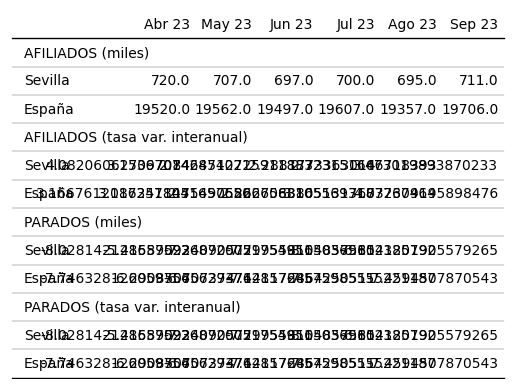

In [101]:
# Tabla parados y afiliaciones (meses)

# 1. Para hacerlos más eficientemente, vamos primero a unir las 4 tablas:
tabla2=parados.merge(parados_tv,on="fecha")
ss.index.name="fecha" # esto es necesario para unir las tablas
ss_tv.index.name="fecha" # esto es necesario para unir las tablas
tabla2=tabla2.merge(ss,on="fecha")
tabla2=tabla2.merge(ss_tv,on="fecha")

# 2. Seleccionarmos los últimos 6 meses
tabla2=tabla2.iloc[-6:]

# 3. Creamos columnas con el nombre de las variables a representar.
tabla2['AFILIADOS (miles)']=""
tabla2['AFILIADOS (tasa var. interanual)']=""
tabla2['PARADOS (miles)']=""
tabla2['PARADOS (tasa var. interanual)']=""

# 4. Dividimos por 1000 las columnas con número de personas
for c in ['Sevilla (par)_x', 'España (par)_x', 'España (Afil)_x', 'Sevilla (Afil)_x']:
  tabla2[c]=round(tabla2[c]/1000)

# 5. Ordenamos las columnas:
tabla2=tabla2[['AFILIADOS (miles)','Sevilla (Afil)_x','España (Afil)_x',
               'AFILIADOS (tasa var. interanual)','Sevilla (Afil)_y','España (Afil)_y',
               'PARADOS (miles)','Sevilla (par)_y','España (par)_y',
               'PARADOS (tasa var. interanual)','Sevilla (par)_y','España (par)_y']]

# 6. Le damos el nombre deseado a las columnas
tabla2.columns=['AFILIADOS (miles)','Sevilla','España',
               'AFILIADOS (tasa var. interanual)','Sevilla','España',
               'PARADOS (miles)','Sevilla','España',
               'PARADOS (tasa var. interanual)','Sevilla','España']

# 6. Transponemos la tabla
tabla2=tabla2.T

# 5. Renombramos las columnas
#    El encabezado de las columnas es ahora este: '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01','2023-08-01', '2023-09-01'
#    Vamos a darle otra lista de etiquetas con mejor formato:
tabla2.columns=["Abr 23","May 23","Jun 23","Jul 23","Ago 23","Sep 23"]

tabla2.index.name = " " # 1 espacio: para que luego no se vea nada.

# Vemos como queda
Table(tabla2,
      column_definitions=[ColumnDefinition(name=" ", width=2, textprops={"ha": "left"})],
      footer_divider=True )

In [98]:
tabla2

,Abr 23,May 23,Jun 23,Jul 23,Ago 23,Sep 23
,,,,,,
AFILIADOS (miles),,,,,,
Sevilla,719.665,707.334,697.334,699.824,694.993,710.751
España,19519.991,19561.827,19497.207,19607.471,19357.319,19706.161
AFILIADOS (tasa var. interanual),,,,,,
Sevilla,4.082061,3.15367,2.746451,2.288177,2.723152,3.47302
España,3.166761,3.017358,2.754906,2.262707,3.105569,4.032309
PARADOS (miles),,,,,,
Sevilla,-8.028142,-5.415891,-7.26872,-7.799558,-8.650369,-6.61412
España,-7.746328,-6.290851,-6.656294,-7.141173,-7.575986,-7.459451
